In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import folium
import nivapy
import seaborn as sn
import glob
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
sn.set_context('notebook')

# NOPE metals (continued)

## Background

The [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_metals_2.ipynb) demonstrated that including atmospheric deposition substantially improves estimates of metal loads for Cd and Pb (compared to the previous approach).

Following on from this, Øyvind G suggested some reading material to better understand metal behaviours (see e-mail from Øyvind K received 13/11/2017 at 15:25). My notes based on these references are here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\NOPE Metals Ideas.docx

For further details, see also the e-mail sent to Øyvind K, Øyvind G and John Rune on 21/11/2017 at 11:45. Øyvind G and I subsequently discussed things further via e-mail (22/11/2017), and this notebook develops these ideas further. 

The specific aims of this notebook are to:

 1. Spatially interpolate the moss data supplied by Øyvind G <br><br>
 
 2. Obtain spatially interpolated geochemical data from NGU's [Geokjemisk Atlas for Norge](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) and reproject these to a common grid compatible with the moss datasets <br><br>
 
 3. Link the moss and geochemical datasets to the catchment data provided by Anders Finstad. Anders' dataset appears to include catchment boundaries for the watersheds upstream of the lakes sampled during the 1995 "1000 lakes" survey. For each catchment, I want to calculate average moss and geochemical concentrations using zonal statistics. In addition, Anders has already calculated catchment characteristics such as averge runoff, mean slope etc., which might help to estimate erosion and transport rates <br><br>
 
 4. Link all of the datasets listed above to the water chemistry data in RESA2 from the "1000 lakes" survey <br><br>
 
 5. Explore some simple statistical models to see if we can predict metal concentrations as a function of: deposition (using mosses as a proxy), geology (using NGU's geochemistry data), catchment properties (from Anders' dataset) and other chemical parameters (primarily pH and TOC)
 
The first step is to establish the necessary database connections.

In [2]:
# Connect to Oracle
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


In [3]:
# Connect to PostGIS
pg_eng = nivapy.da.connect(src='postgres')

Username: ········
Password: ········
Connection successful.


## 1. Define common co-ordinate reference system

For the zonal statistics calculations, all the datasets need spatially interpolating and re-projecting onto a common grid. For Norway at national scale, I have previously used an Albers Equal Area projection. The map below shows [Tissot indicatrices](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) for this projection, illustrating that the distortion over Norway is fairly minimal.

C:\Data\Anaconda2\lib\site-packages\cartopy\mpl\geoaxes.py:598: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000000001274DEB8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


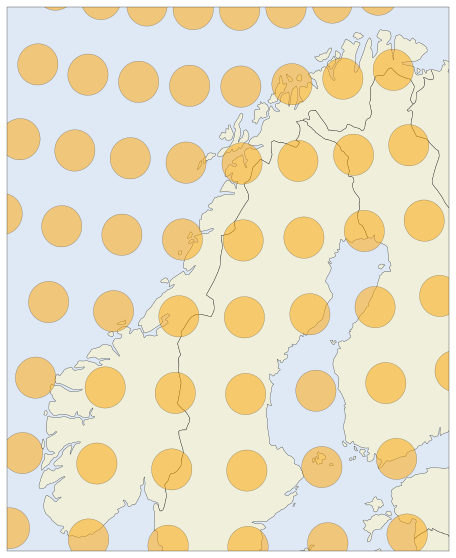

In [4]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(central_longitude=15, 
                           central_latitude=65, 
                           false_easting=650000, 
                           false_northing=800000,
                           standard_parallels=(55, 75))

# Setup plot
fig = plt.figure(figsize=(10,10))
crs_ax = fig.add_subplot(1,1,1, projection=crs)
crs_ax.set_extent([0, 1300000, 0, 1600000], crs=crs) # Values in metres
                                                     # Originally found using Basemap

# Add Natural Earth data
# Land
land_50m = cfeature.NaturalEarthFeature(category='cultural',
                                        name='admin_0_countries', 
                                        scale='50m',
                                        edgecolor='black',
                                        facecolor=cfeature.COLORS['land'])
crs_ax.add_feature(land_50m)

# Sea
sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                       name='ocean',
                                       scale='50m',
                                       edgecolor='none',
                                       facecolor=cfeature.COLORS['water'],
                                       alpha=0.3)
crs_ax.add_feature(sea_50m)

# Draw Tissot indicatrices to show distortion
lons = range(0, 30, 4)
lats = range(40, 80, 2)
crs_ax.tissot(rad_km=60000.0,     # Actually in metres. Fixed in v0.16?
              lons=lons, 
              lats=lats, 
              n_samples=100,      # Number of points for each circle
              facecolor='orange',
              edgecolor='black',
              alpha=0.5)

The code below creates a GeoTiff file with 1 km resolution covering exactly the area shown above. This grid will be used as a "snap raster" in all subsequent calculations.

In [5]:
# Set up 1 km grid
cell_size = 1000 # metres

# Extent
bbox = [round(i) for i in crs_ax.get_extent()]
xmin, xmax, ymin, ymax = bbox

# Rows and cols
cols = int(xmax - xmin) / cell_size 
rows = int(ymax - ymin) / cell_size
ones = np.ones(shape=(rows, cols))

# Write to GeoTiff
gtif_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\GIS\Raster\norway_aea_1km_snap_ras.tif')
nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, gtif_path, ones, 
                              crs_ax.projection.proj4_init)

## 2. Spatially interpolate moss data

### 2.1. Visualise point data

The code below focuses on the 1990 moss survey. Ideally we should use the moss data from 1995 instead, as this is more directly comparable with the measurements from the 1995 lakes survey. However, Øyvind G does not have co-ordinate information for this dataset (see e-mail received 23/11/2017 at 10.00), so I'll work with the 1990 data for now and follow-up the 1995 data if the approach looks promising.

**Note:** Some of the concentration values in the raw data are less than 0. These are set to 0 in the code below.

In [6]:
# Read moss data
year = 1990
moss_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\Raw_Datasets\Moss_Surveys\moss_data_tidied.xlsx')
moss_df = pd.read_excel(moss_xlsx, sheetname='mosses_%s' % year)

# Set negative to zero
moss_df[moss_df<0] = 0

moss_df.head()

lat    lon     cr       ni      cu      zn     as     cd    pb
0  69.10  28.58   0.94   13.744   14.75  25.973  0.639  0.092  3.91
1  69.21  29.29   2.31   36.442   32.44  36.231  1.243  0.183  3.89
2  69.28  30.04   4.03  133.486  119.58  43.015  2.168  0.233  4.15
3  69.41  30.00  10.37   39.482   39.81  41.228  1.054  0.054  8.15
4  69.46  30.11   2.51   33.059   32.34  41.945  0.606  0.086  4.29

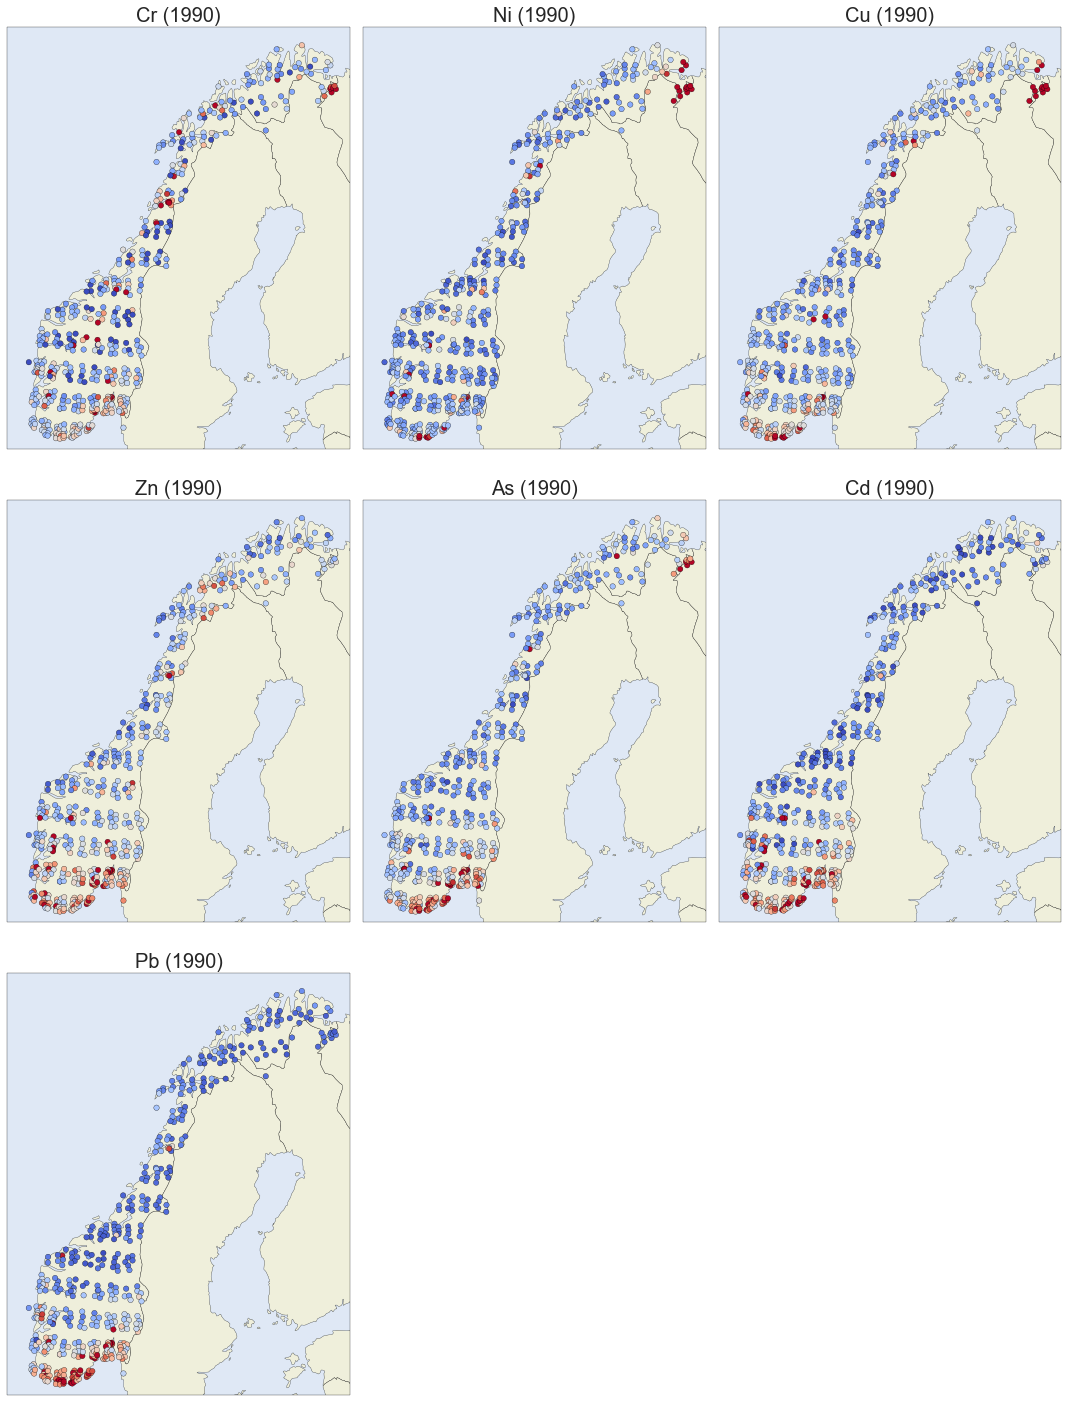

In [7]:
# Plot data
fig = plt.figure(figsize=(15, 20))

# Loop over pars
pars = [i for i in moss_df.columns if i not in ['lat', 'lon']]
for idx, par in enumerate(pars):
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')
    
    # Add subplot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)

    # Add geo data
    ax.add_feature(land_50m)
    ax.add_feature(sea_50m)

    # Set max value for colour ramp at 95th percentile
    # (otherwise compressed by outliers)
    pct = df[par].describe(percentiles=[0.95,]).ix['95%']
    
    # Add points using linear colour ramp from 0 to 95th percentile   
    ax.scatter(df['lon'].values, 
               df['lat'].values, 
               c=df[par].values, 
               cmap='coolwarm', 
               vmax=pct, 
               s=30, 
               zorder=5,
               edgecolors='k', 
               transform=ccrs.PlateCarree())
    
    ax.set_title('%s (%s)' % (par.capitalize(), year), fontsize=20)

plt.tight_layout()

These plots illustrate the relationships expected based on my earlier reading: Zn, As, Cd and Pb all show a similar pattern, which is strongly influenced by LRTAP (and some short-range air pollution near the Russian border); Cr, Ni and Cu are less obviously determined by LRTAP, although the short-range influence near Russia is still obvious.

### 2.2. Interpolation

The next step is to interpolate this point data onto the grid defined in section 1. The best option for this would probably be kriging, but as the point density is fairly high I should be able to achieve adequate results more easily using [IDW](https://en.wikipedia.org/wiki/Inverse_distance_weighting), cubic splines or bilinear interpolation. The code below applies all three methods for Cr and Pb (representing the two different "types" of metal behaviour) and saves the results as GeoTiffs. Based on these results, I can then pick one interpolation method and apply it to the rest of the data.

In [8]:
# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\moss_data')

# Set up grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size/2.)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size/2.)

# Loop over pars
for par in ['cr', 'pb']: 
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')  

    # Map (long, lat) to projected (x, y) and reformat to syntax required 
    # by interp algorithms
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=8, p=2)
    idw[idw<0] = 0

    # Spline interpolation
    spl = nivapy.spatial.interp_cubic_spline(pts, vals, gridx, gridy)
    spl[spl<0] = 0

    # Bilinear interpolation
    bil = nivapy.spatial.interp_bilinear(pts, vals, gridx, gridy)
    bil[bil<0] = 0

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)
    
    # Spline
    spl_path = os.path.join(out_fold, 'moss_%s_%s_spline.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, spl_path, spl, 
                                  crs_ax.projection.proj4_init)
    
    # Bilinear
    bil_path = os.path.join(out_fold, 'moss_%s_%s_bilinear.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, bil_path, bil, 
                                  crs_ax.projection.proj4_init)

C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in less
C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: invalid value encountered in less


The plots below compares these three different interpolation methods for Pb and Cr.

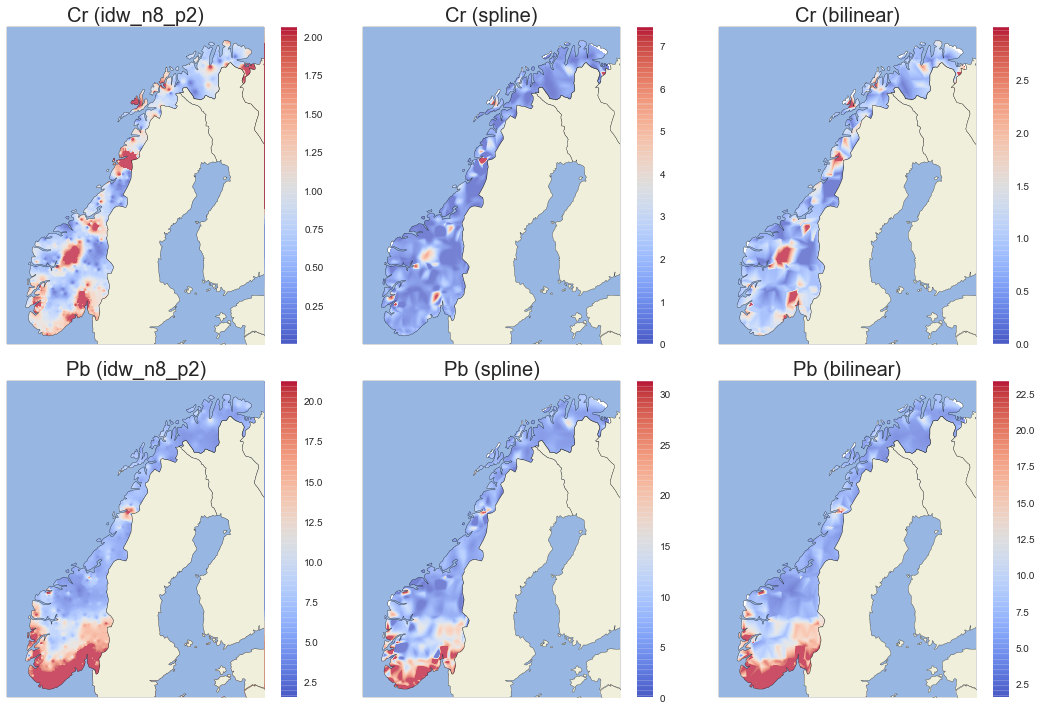

In [9]:
# Setup fig
fig = plt.figure(figsize=(15, 10))

# Adjust alpha sea
sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                       name='ocean',
                                       scale='50m',
                                       edgecolor='none',
                                       facecolor=cfeature.COLORS['water'],
                                       alpha=1)

# Counter for incrementing plot numbers
cnt = 0

# Loop over data
for par in ['cr', 'pb']:
    for meth in ['idw_n8_p2', 'spline', 'bilinear']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(out_fold, 
                                  'moss_%s_%s_%s.tif' % (year, par, meth))
        data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]
               
        # Plot
        ax = fig.add_subplot(2, 3, cnt, projection=crs)
        ax.set_extent(bbox, crs=crs)
        ax.set_title('%s (%s)' % (par.capitalize(), meth), fontsize=20)
        cax = ax.imshow(data, 
                        zorder=1,
                        extent=bbox,
                        cmap='coolwarm', 
                        alpha=0.7, 
                        interpolation='none',
                        vmax=np.nanpercentile(data, 95))
        
        # Add colourbar
        cbar = fig.colorbar(cax)
        
        # Get countries. Make Norway "hollow" so interpolated vaues
        # are visible. Make everywhere else opaque to mask wildly extrapolated
        # values
        shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                                   category='cultural',
                                                   name='admin_0_countries')
        reader = cartopy.io.shapereader.Reader(shp)
        countries = reader.records()

        # Loop over countries
        for country in countries:
            if country.attributes['NAME'] == 'Norway':
                # Transparent
                ax.add_geometries(country.geometry, 
                                  ccrs.PlateCarree(), # CRS of Natural Earth data
                                  facecolor='none', 
                                  edgecolor='black',
                                  zorder=5,)
            else:
                # Opaque
                ax.add_geometries(country.geometry, 
                                  ccrs.PlateCarree(), # CRS of Natural Earth data
                                  facecolor=cfeature.COLORS['land'],
                                  edgecolor='black',
                                  zorder=5)
        
        # Add sea
        ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

Looking at these maps, the results for IDW and bilinear interpolation are fairly similar, whereas the cubic splines method produces more extreme values (i.e. a more "spiky" surface). IDW tends to "clip off" peaks due to averaging, but overall the output looks pretty good to me. IDW also seems to do a better job of representing the high values close to the Russian border, so for the rest of this analysis I'll continue with IDW. 

The code below performs IDW interpolation for all parameters.

In [10]:
# Loop over pars
for par in pars: 
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')  

    # Map (long, lat) to projected (x, y) and reformat to syntax required 
    # by interp algorithms
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=8, p=2)

    # Save output
    idw_path = os.path.join(out_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)

And here are the plots of the IDW-interpolated grids:

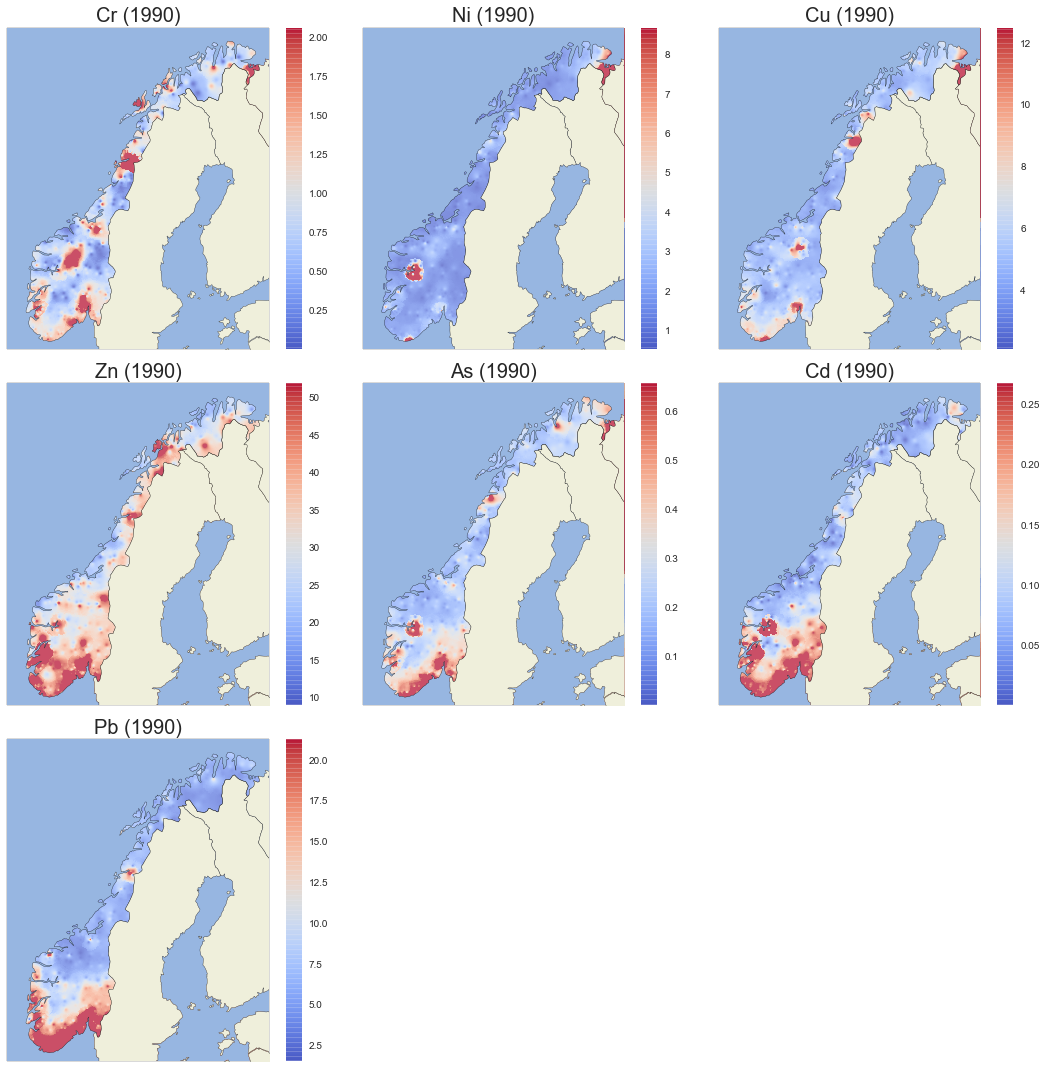

In [11]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(pars):       
    # Read data
    gtiff_path = os.path.join(out_fold, 
                              'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)
    ax.set_title('%s (%s)' % (par.capitalize(), year), fontsize=20)
    cax = ax.imshow(data, 
                    zorder=1,
                    extent=bbox,
                    cmap='coolwarm', 
                    alpha=0.7, 
                    interpolation='none',
                    vmax=np.nanpercentile(data, 95))

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Get countries. Make Norway "hollow" so interpolated vaues
    # are visible. Make everywhere else opaque to mask wildly extrapolated
    # values
    shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                               category='cultural',
                                               name='admin_0_countries')
    reader = cartopy.io.shapereader.Reader(shp)
    countries = reader.records()

    # Loop over records
    for country in countries:
        if country.attributes['NAME'] == 'Norway':
            # Transparent
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor='none', 
                              edgecolor='black',
                              zorder=5,)
        else:
            # Opaque
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor=cfeature.COLORS['land'],
                              edgecolor='black',
                              zorder=5)

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

## 3. Spatially interpolate geochemical data

Tor Erik Finne at NGU has kindly supplied the point data underpinning the [Geokjemisk Atlas for Norge](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) (see e-mail received 23/11/2017 at 13.57). The geochemical workflow is similar to that for the moss data: I first want to visualise the point data to get an idea of its distribution, then interpolate it onto a standard grid for further analysis.

Some key points to note regarding the geochemical data:

 * Values are available from two different analysis procedures: extract using nitric acid and "total" content estimated using X-ray fluorescence (XRF). The XRF data is probably preferable, but unfortunately does not include As. At present, I'm mostly interested in having values that are **proportional to** metal concentrations, rather than accurate absolute measurements. I will therefore use the nitric acid data in the analysis below <br><br>
 
 * However, I would also like to check that my interpolation procedure is reasonable, and the only data I have to compare against is the image for Cr from the [NGU website](https://www.ngu.no/emne/naturlige-bakgrunnsverdier), which is based on the "total" XRF data. I will therefore first interpolate the total XRF Cr data to see whether I get a comparable image, and if everything looks OK I'll apply the same approach to the nitric acid data <br><br>
 
 * Most of the samples (612 out of 690) come from 10 cm depth. The remainder are "integrated" samples covering a range of depth intervals. At least initially, I will use all the available data, but it may be necessary to revise this if nearby values from different depths causes problems for the interpolation algorithm <br><br>
 
 * All of the measurements were taken during 1984 and 1985 <br><br>
 
 * All units are given as **parts per million (ppm)**. It is not specified whether this is by mass or by volume, but the example map for Cr [here](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) gives the units as mg/kg (i.e. ppm by mass). I will therefore assume that all values in the spreadsheet are also mg/kg.

### 3.1. Compare Cr data to figure from Geochemical Atlas

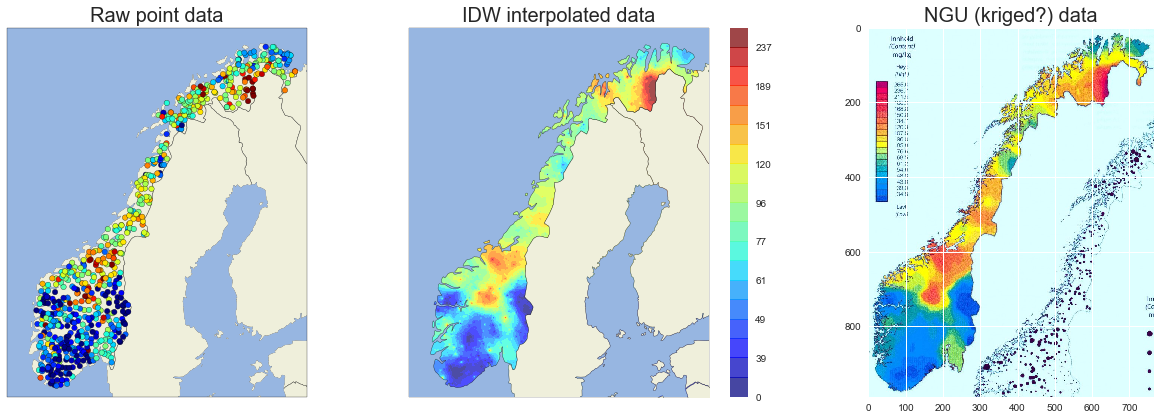

In [12]:
# Read Cr data
geo_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\ngu_geochem_tidied.xlsx')
df = pd.read_excel(geo_xlsx, sheetname='total_xrf')
df = df[['lat', 'lon', 'cr']].dropna(how='any')

# The single value of 4484 mg/kg is a HUGE outlier (see below)
# Remove
df = df.query('cr < 1000')

# Map (long, lat) to projected (x, y) 
pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                           x=df['lon'].values, 
                           y=df['lat'].values)[:, :2]

# Get values to interpolate
vals = df['cr'].values

# Interpolate
idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

# Plot
fig = plt.figure(figsize=(18, 6))

# Construct a colourmap roughly comparable to the one used by NGU
# NB: my matching here is only partially successful
base = plt.cm.get_cmap('jet')
bnds = np.array([0,35,39,44,49,55,61,69,    # From NGU map
                 77,86,96,108,120,135,151,
                 169,189,212,237,265])
norm = matplotlib.colors.BoundaryNorm(bnds, base.N)

# 1. Point data
ax = fig.add_subplot(1, 3, 1, projection=crs)
ax.set_extent(bbox, crs=crs)

# Add geo data
ax.add_feature(land_50m)
ax.add_feature(sea_50m)

# Add points  
ax.scatter(df['lon'].values, 
           df['lat'].values, 
           c=df['cr'].values, 
           cmap='jet',        
           norm=norm,           
           s=30, 
           zorder=5,
           edgecolors='k', 
           transform=ccrs.PlateCarree())
ax.set_title('Raw point data', fontsize=20)

# 2. Interpolated data
ax = fig.add_subplot(1, 3, 2, projection=crs)
ax.set_extent(bbox, crs=crs)
ax.set_title('IDW interpolated data', fontsize=20)
cax = ax.imshow(idw, 
                zorder=1,
                extent=bbox,
                cmap='jet',           
                alpha=0.7, 
                interpolation='none',
                norm=norm)             
cbar = fig.colorbar(cax)

# Get country data 
shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                           category='cultural',
                                           name='admin_0_countries')
reader = cartopy.io.shapereader.Reader(shp)
countries = reader.records()

# Loop over countries
for country in countries:
    if country.attributes['NAME'] == 'Norway':
        # Transparent
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor='none', 
                          edgecolor='black',
                          zorder=5,)
    else:
        # Opaque
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor=cfeature.COLORS['land'],
                          edgecolor='black',
                          zorder=5)

# Add sea
ax.add_feature(sea_50m, zorder=4)

# 3. Add NGU image (NB: not properly georeferenced!)
ax = fig.add_subplot(1, 3, 3)
im_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\Geochem_Atlas_Cr_Example.jpg')
img=mpimg.imread(im_path)
ax.imshow(img)
ax.set_title('NGU (kriged?) data', fontsize=20)

plt.tight_layout()

Based on these maps, I'd say the interpolation is working pretty well. The main differences between my IDW version and the one published in the Geochemical Atlas are explained by the choices of colour scheme: on the NGU map, bright yellow corresponds to values around 85 mg/kg, whereas on my version it's more like 120 mg/kg. I could spend longer attempting to match the colour schemes, but I don't think it's necessary - these results seem reasonable to me.

Note, however, that in the code above I've changed the p-exponent for the IDW algorithm to 1 (instead of 2), and also increased the number of nearest neighbours from 8 (for the mosses) to 20, as these values give results that are more comparable to the NGU map. The p-exponent determines how quickly spatial weights decline with distance: a value of 1 means the weights are proportional to $\frac{1}{d}$, whereas a value of 2 corresponds to $\frac{1}{d^2}$. Using `p=1` and `n_near=20` therefore results in more spatial averaging, and this seems to work well for the geochemical data.

Note also that there is a single point in the Cr dataset with a value of 4484 mg/kg. The next biggest value is 484 mg/kg, so a value of >4000 is a pretty huge outlier. I assume there's something wrong with this measurement (especially since the nitric acid extract data does not include any such outliers), so I have removed it from consideration in the code above.

In the nitric acid data, there is a similar outlier for Ni (max 1100 mg/kg; next largest value 282 mg/kg), which I will also remove from consideration (see code below). 

### 3.1. Visualise point data

Using the results above as a guide, I can now process the **nitric acid extract** data for all metals.

In [13]:
# Read geo data
geo_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\ngu_geochem_tidied.xlsx')
geo_df = pd.read_excel(geo_xlsx, sheetname='nitric_acid')

# Delete unnecessary cols
del geo_df['date'], geo_df['from_depth'], geo_df['to_depth']

geo_df.head()

lon        lat     cr     ni    cu      zn    as    pb
0   9.705842  62.880829  87.09  38.99  14.0   33.93  1.62  14.0
1  10.897466  60.035979  31.82  21.53  13.0  101.50  3.12  14.0
2  11.077467  60.427157  23.75   9.42  12.0   35.03  1.00  18.0
3   5.827683  61.205022  10.63   8.20  14.0   46.03  0.97  20.0
4   8.396488  61.747305  54.09  14.30  57.0   18.17  0.56   5.0

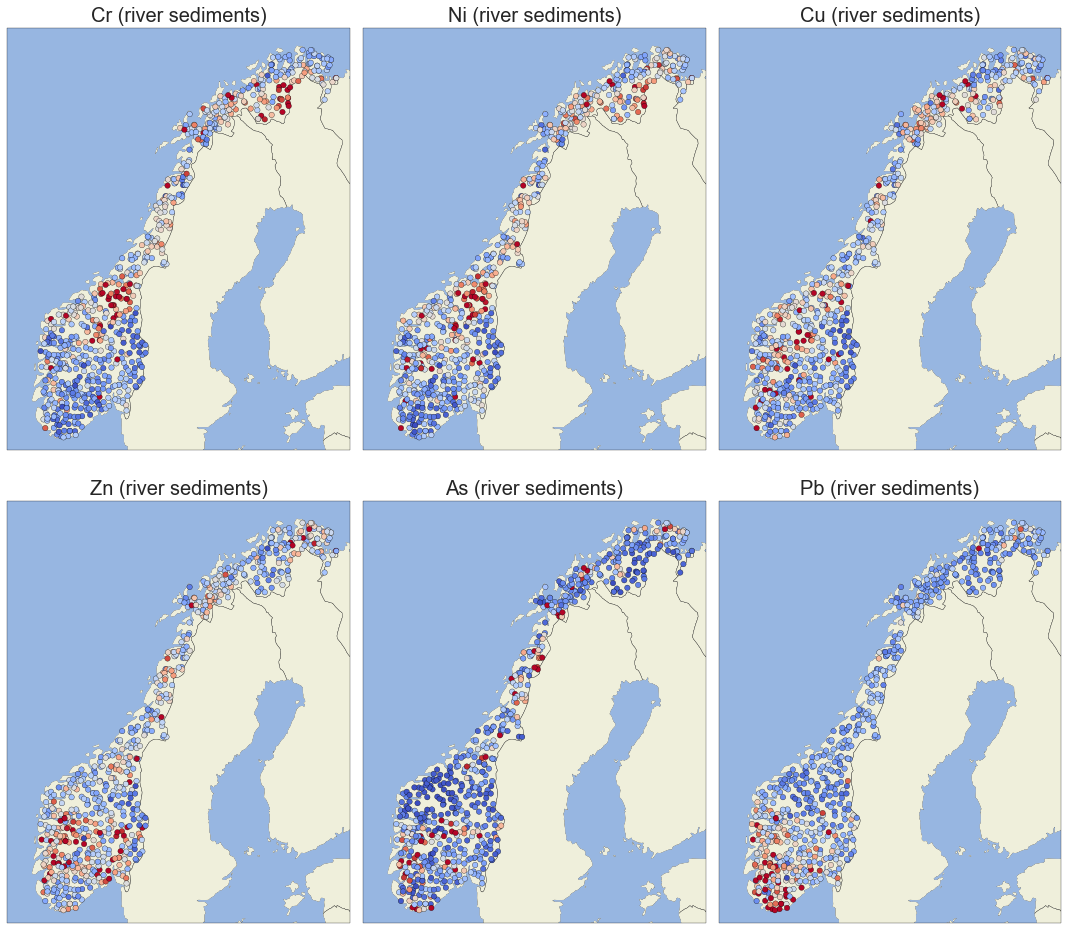

In [14]:
# Plot data
fig = plt.figure(figsize=(15, 20))

# Loop over pars
pars = [i for i in geo_df.columns if i not in ['lat', 'lon']]
for idx, par in enumerate(pars):
    # Get data
    df = geo_df[['lat', 'lon', par]].dropna(how='any')
    
    # Remove outlier for Ni
    if par == 'ni':
        df = df.query('ni < 1000')
    
    # Add subplot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)

    # Add geo data
    ax.add_feature(land_50m)
    ax.add_feature(sea_50m)

    # Set max value for colour ramp at 95th percentile
    # (otherwise compressed by outliers)
    pct = df[par].describe(percentiles=[0.95,]).ix['95%']
    
    # Add points using linear colour ramp from 0 to 95th percentile   
    ax.scatter(df['lon'].values, 
               df['lat'].values, 
               c=df[par].values, 
               cmap='coolwarm', 
               vmax=pct, 
               s=30, 
               zorder=5,
               edgecolors='k', 
               transform=ccrs.PlateCarree())
    
    ax.set_title('%s (river sediments)' % par.capitalize(), fontsize=20)

plt.tight_layout()

### 3.2. Interpolation

The code below uses IDW interpolation to convert the geochemical point data to a regular grid. Based on the tests above, I'm using `p=1` and `n_near=20` for the IDW parameters.

In [15]:
# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\geochem_data')

# Loop over pars
for par in pars: 
    # Get data
    df = geo_df[['lat', 'lon', par]].dropna(how='any')  

    # Remove outlier for Ni
    if par == 'ni':
        df = df.query('ni < 1000')
        
    # Map (long, lat) to projected (x, y)
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

    # Save output
    idw_path = os.path.join(out_fold, 'geochem_%s_idw_n20_p1.tif' % par)
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)

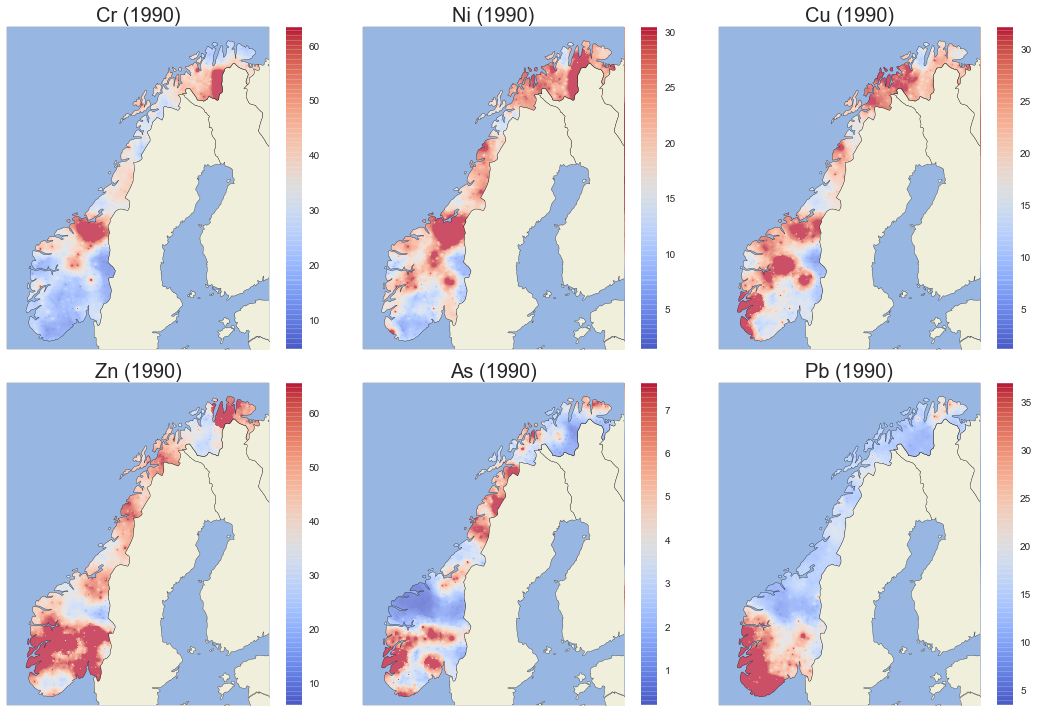

In [16]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(pars):       
    # Read data
    gtiff_path = os.path.join(out_fold, 
                              'geochem_%s_idw_n20_p1.tif' % par)
    data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)
    ax.set_title('%s (%s)' % (par.capitalize(), year), fontsize=20)
    cax = ax.imshow(data, 
                    zorder=1,
                    extent=bbox,
                    cmap='coolwarm', 
                    alpha=0.7, 
                    interpolation='none',
                    vmax=np.nanpercentile(data, 95))

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Get countries. Make Norway "hollow" so interpolated vaues
    # are visible. Make everywhere else opaque to mask wildly extrapolated
    # values
    shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                               category='cultural',
                                               name='admin_0_countries')
    reader = cartopy.io.shapereader.Reader(shp)
    countries = reader.records()

    # Loop over records
    for country in countries:
        if country.attributes['NAME'] == 'Norway':
            # Transparent
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor='none', 
                              edgecolor='black',
                              zorder=5,)
        else:
            # Opaque
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor=cfeature.COLORS['land'],
                              edgecolor='black',
                              zorder=5)

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

## 4. Zonal statistics

The next step is to get the catchment boundaries supplied by Anders Finstad and caclulate summary statistics for each catchment based on the interpolated moss and geochemical datasets.

### 4.1. Get catchment data

The data supplied by Anders is quite complex, and I have previously added it to my local PostGIS database. For the analysis here, I'm only interested in a small subset of the available catchment properties. The code below extracts the data, reprojects it, and save it as a shapefile for further processing.

In [17]:
# Extract catchment data 
sql = ("SELECT geom, "
       "  lake_id, "
       "  lake_name AS name, "
       "  altitude_average AS alt_avg, "
       "  slope_average AS slp_avg, "
       "  slope_var AS slp_var, "
       "  catchment_area_km2 AS area_km2 "
       "FROM niva_work.nope_metals.ecco_biwa "
       "WHERE nation = 'Norway'")
crs = {'init': 'epsg:25833'} # UTM Zone 33N ETRS89
cat_gdf = gpd.GeoDataFrame.from_postgis(sql, geom_col='geom', 
                                        crs=crs, con=pg_eng)

# Reproject to common crs
cat_gdf = cat_gdf.to_crs(crs_ax.projection.proj4_init)

# Save
shp_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\GIS\Vector\lakes_1k_catchments.shp')
cat_gdf.to_file(shp_path)

print 'Total number of catchments:', len(cat_gdf)
cat_gdf.head()

Total number of catchments: 990


geom   lake_id  \
0  (POLYGON ((462822.5019760047 155364.9632065317...   118-1-7   
1  (POLYGON ((441389.0901590431 229329.4787081783...   227-2-1   
2  (POLYGON ((158124.9434222006 380704.3963597477...  1266-2-1   
3  (POLYGON ((217211.1767291659 223269.2287373355...   834-4-7   
4  (POLYGON ((526006.6282515525 695245.8187160539...  1736-1-2   

             name      alt_avg    slp_avg     slp_var  area_km2  
0          HOH113   117.429493   1.283039    2.518281    0.4296  
1            Heia   220.582426   6.982528   41.813836   17.5300  
2  Svadfjellvatni   869.364951  15.021529  142.861185    1.4942  
3     Holmavatnet  1158.677692   8.045503   77.777198   54.2214  
4       Fiskløysa   647.525184   7.544434   73.569782    0.2438

### 4.2. Calculate statistics

I have previously written code for calculating zonal statistics that is more flexible (and much faster) than the algorithms available in ArcGIS. In particular, the zonal statistics code I have recently added to nivapy is capable of dealing with overlapping polygons, which is a requirement for the work here. The downside of my code is that cells are only assigned to catchments when the cell centre falls within the catchment boundary, and as we're using a 1 km resolution grid it is possible  for very small catchments (<< 1 km) to end up not being associated with any raster cells. I'll ignore this for now and will return to it if it seems to be causing major problems.

In [18]:
# GeoTiff folders
moss_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\GIS\Raster\moss_data')

geo_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\geochem_data')

# Container for data
df_list = []

# Loop over moss data
pars = [i for i in moss_df.columns if i not in ['lat', 'lon']]
for par in pars:
    # Get path to raster
    ras_path = os.path.join(moss_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    
    # Calc stats
    stat_df = nivapy.spatial.zonal_stats(shp_path, ras_path)
    
    # Set index
    stat_df.index = stat_df['fid']
    del stat_df['fid']
    
    # Get just mean and std. dev.
    stat_df = stat_df[['mean', 'std']]
    stat_df.columns = ['%s_moss_%s' % (par, i) for i in stat_df.columns]
    
    # Add to output
    df_list.append(stat_df)

# Loop over geochem data
pars = [i for i in geo_df.columns if i not in ['lat', 'lon']]
for par in pars:
    # Get path to raster
    ras_path = os.path.join(geo_fold, 'geochem_%s_idw_n20_p1.tif' % par)
    
    # Calc stats
    stat_df = nivapy.spatial.zonal_stats(shp_path, ras_path)
    
    # Set index
    stat_df.index = stat_df['fid']
    del stat_df['fid']
    
    # Get just mean and std. dev.
    stat_df = stat_df[['mean', 'std']]
    stat_df.columns = ['%s_geo_%s' % (par, i) for i in stat_df.columns]
    
    # Add to output
    df_list.append(stat_df)
    
# Merge into a single dataset
stat_df = pd.concat(df_list, axis=1)

# Convert catchments to plain df
cols = [i for i in cat_gdf.columns if i != 'geom']
cat_df = pd.DataFrame(cat_gdf[cols])

# Join to stats
cat_df = pd.merge(cat_df, stat_df, how='left',
                  left_index=True, right_index=True)

cat_df.head()

C:\Data\Anaconda2\lib\site-packages\nivapy\spatial.py:726: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  src_array == nodata_value,
C:\Data\Anaconda2\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


lake_id            name      alt_avg    slp_avg     slp_var  area_km2  \
0   118-1-7          HOH113   117.429493   1.283039    2.518281    0.4296   
1   227-2-1            Heia   220.582426   6.982528   41.813836   17.5300   
2  1266-2-1  Svadfjellvatni   869.364951  15.021529  142.861185    1.4942   
3   834-4-7     Holmavatnet  1158.677692   8.045503   77.777198   54.2214   
4  1736-1-2       Fiskløysa   647.525184   7.544434   73.569782    0.2438   

   cr_moss_mean  cr_moss_std  ni_moss_mean  ni_moss_std     ...      \
0           NaN          NaN           NaN          NaN     ...       
1      1.214896     0.012136      1.285772     0.019558     ...       
2      0.512598     0.000000      1.230189     0.000000     ...       
3      0.492168     0.038776      1.391590     0.020486     ...       
4           NaN          NaN           NaN          NaN     ...       

   ni_geo_mean  ni_geo_std  cu_geo_mean  cu_geo_std  zn_geo_mean  zn_geo_std  \
0          NaN         NaN          NaN         NaN          NaN         NaN   
1    19.321605    0.078496    15.019806    0.299359    66.668329    0.938914   
2    14.025681    0.000000    19.028118    0.000000    51.021477    0.000000   
3    13.263595    0.284236    33.715892    1.027701    82.980143    2.064754   
4          NaN         NaN          NaN         NaN          NaN         NaN   

   as_geo_mean  as_geo_std  pb_geo_mean  pb_geo_std  
0          NaN         NaN          NaN         NaN  
1     2.664654    0.037276    21.327126    0.079329  
2     5.296702    0.000000    37.623196    0.000000  
3     7.298749    0.226702    45.396441    1.280797  
4          NaN         NaN          NaN         NaN  

[5 rows x 32 columns]

## 5. Lake chemistry data

The next step is to add in data from the 1995 "1000 lake" survey.

### 5.1. Search RESA2 stations

In [19]:
# Search projects
prj_df = nivapy.da.search_projects("project_name LIKE 'Regional%'", ora_eng)
prj_df

project_id project_number               project_name contact_person  \
0          27           None  Regionalundersøkelse 1995           RESA   
1          81           None  Regionalundersøkelse 1986           None   

                                 project_description  
0  Tusensjøersundersøkelsen 1995 med etterfølgend...  
1  Tusensjøers undersøkelsen 1986 samt nyere data...

In [20]:
# Get stations for 1995 survey
stn_df = nivapy.da.select_project_stations([27,], ora_eng)

print 'Number of stations:', len(stn_df)
stn_df.head()

Number of stations: 1006


station_id station_code    station_name   latitude  longitude  altitude
0         115      831-501       BrÃ¥rvatn  59.294921   7.727118     902.0
1         116     1640-603       Tufsingen  62.612294  11.876558     781.0
2         125     2030-607    St.Valvatnet  69.694975  30.656211     157.0
3         135     1228-501      Steinavatn  59.859877   6.578783    1047.0
4         166       1018-4  Kleivsetvannet  58.119559   7.664899      93.0

It is useful to compare the station locations in RESA2 to the catchment data provided by Anders. In order to do this in an interactive way, I need to simplify the catchment polygons. The code below uses PostGIS' `ST_SimplifyPreserveTopology` to create a lower-resolution version of the catchment dataset. It also extracts only the polygons located within Norway, which should keep file sizes manageable. Downsampling is achieved using the [Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm), but with the additional constraint that topological relationships are presereved. I have allowed vector nodes to be moved by up to a maximum of 1 km during the simplification process.

In [21]:
# Extract simplified catchments and avg_slope data 
sql = ("SELECT ST_SimplifyPreserveTopology(geom, 1000) AS geom, "
       "  slope_average AS slp_avg "
       "FROM niva_work.nope_metals.ecco_biwa "
       "WHERE nation = 'Norway'")
crs = {'init': 'epsg:25833'} # UTM Zone 33N ETRS89
gdf = gpd.GeoDataFrame.from_postgis(sql, geom_col='geom', crs=crs, con=pg_eng)

# Choropleth of avg_slp from catchment data
map1 = nivapy.spatial.choropleth_from_gdf(gdf, 'slp_avg', fill_opacity=0.5,
                                          legend_name='Average slope (degrees)')

# Add station locs from RESA2
map1 = nivapy.spatial.quickmap(stn_df, popup='code', map_obj=map1)

map1

### 5.2. Extract water chemistry from "1000 lakes" survey

The code below extracts all the 1995 chemistry data for the "1000 lakes" survey.

In [23]:
# Pars of interest
par_list = ['Ag', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'pH', 'TOC']

# Container for results
df_list = []

# Loop over stations
for stn_id in stn_df['station_id']:
    # Get all Al data
    wc_df, dup_df = nivapy.da.extract_water_chem(stn_id, par_list,
                                                 '1995-01-01', 
                                                 '1995-12-31',
                                                 ora_eng,
                                                 plot=False)
    
    # Tidy
    wc_df['station_id'] = stn_id
    wc_df.reset_index(inplace=True)
    df_list.append(wc_df)  

# Combine output
wc_df = pd.concat(df_list, axis=0)

#  Annual means for each site
wc_df['year'] = wc_df['sample_date'].dt.year
an_df = wc_df.groupby(['year', 'station_id']).mean()

# Reset index
an_df.columns = [i.split('_')[0] for i in an_df.columns]
an_df.reset_index(inplace=True)
del an_df['year']

# Join and drop NaN
wc_df = pd.merge(stn_df[['station_id', 'latitude', 'longitude']],
                 an_df, how='left', on='station_id')
wc_df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Set negative values to zero
wc_df[wc_df < 0] = 0

wc_df.head()

station_id   latitude  longitude   Ag   As    Cd   Cr   Cu   Ni    Pb  \
0         115  59.294921   7.727118  0.0  NaN  0.03  0.0  0.3  0.2  0.35   
1         116  62.612294  11.876558  NaN  0.0  0.00  0.0  0.0  0.0  0.05   
2         125  69.694975  30.656211  NaN  NaN   NaN  NaN  2.0  6.0   NaN   
3         135  59.859877   6.578783  NaN  NaN  0.02  0.5  1.5  0.2  4.09   
4         166  58.119559   7.664899  0.0  NaN  0.17  0.2  0.9  0.8  1.39   

    TOC    Zn    pH  
0  0.55   3.2  5.79  
1  1.50   0.9  6.48  
2  1.20   NaN  6.44  
3  0.20   2.1  5.11  
4  4.70  19.8  5.00

### 5.3. Link lake chemistry to moss and geochemistry datasets

This step should be fairly straightforward, but it seems there are many cases where the `lake_id` column in Anders' dataset does not macth any `station_code` in RESA2. Some stations *can* be matched, and I can't see any other columns in the datasets that could be used instead, but it looks as though more work will be required to link the catchment data to the water chemistry records. If necessary, I can try a spatial join next week.

To be continued...

In [27]:
cat_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\catchment_data.csv')
cat_df.to_csv(cat_csv, encoding='utf-8')

In [30]:
# Join stn_code to water chem
df = pd.merge(wc_df, stn_df[['station_id', 'station_code']],
              how='left', on='station_id')

wc_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\Metals\lake_1k_chem.csv')
df.to_csv(wc_csv, encoding='utf-8')

df.head()

station_id   latitude  longitude   Ag   As    Cd   Cr   Cu   Ni    Pb  \
0         115  59.294921   7.727118  0.0  NaN  0.03  0.0  0.3  0.2  0.35   
1         116  62.612294  11.876558  NaN  0.0  0.00  0.0  0.0  0.0  0.05   
2         125  69.694975  30.656211  NaN  NaN   NaN  NaN  2.0  6.0   NaN   
3         135  59.859877   6.578783  NaN  NaN  0.02  0.5  1.5  0.2  4.09   
4         166  58.119559   7.664899  0.0  NaN  0.17  0.2  0.9  0.8  1.39   

    TOC    Zn    pH station_code  
0  0.55   3.2  5.79      831-501  
1  1.50   0.9  6.48     1640-603  
2  1.20   NaN  6.44     2030-607  
3  0.20   2.1  5.11     1228-501  
4  4.70  19.8  5.00       1018-4

In [31]:
# Combine catchment and water chem data
df = pd.merge(df, cat_df, how='left', left_on='station_code',
              right_on='lake_id')

comb_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\lake_1k_all_data.csv')
df.to_csv(comb_csv, encoding='utf-8')

df.head(20)

station_id   latitude  longitude   Ag     As    Cd   Cr   Cu   Ni    Pb  \
0          115  59.294921   7.727118  0.0    NaN  0.03  0.0  0.3  0.2  0.35   
1          116  62.612294  11.876558  NaN  0.000  0.00  0.0  0.0  0.0  0.05   
2          125  69.694975  30.656211  NaN    NaN   NaN  NaN  2.0  6.0   NaN   
3          135  59.859877   6.578783  NaN    NaN  0.02  0.5  1.5  0.2  4.09   
4          166  58.119559   7.664899  0.0    NaN  0.17  0.2  0.9  0.8  1.39   
5          171  66.750981  15.410237  0.0    NaN  0.00  0.0  0.0  0.0  0.00   
6          187  61.151399  11.623626  0.0    NaN  0.00  0.1  0.4  0.3  0.38   
7          193  64.277881  10.986769  NaN  0.000  0.00  0.0  0.0  0.0  0.19   
8           10  59.808647  11.850279  0.0    NaN  0.03  0.2  0.4  0.3  1.39   
9            9  59.004421  11.563584  NaN  0.491  0.06  0.5  0.5  0.7  1.19   
10          11  60.060220  12.446706  0.0    NaN  0.13  0.2  0.5  0.4  0.66   
11          12  60.328576  11.842177  0.0    NaN  0.04  0.3  0.4  0.6  2.10   
12          13  60.590732  12.517008  0.0    NaN  0.00  0.2  0.4  0.5  0.82   
13          14  61.822223  11.183448  0.0    NaN  0.00  0.0  0.3  0.4  0.16   
14          15  62.236162  11.136193  NaN  0.000  0.00  0.1  0.0  0.0  0.16   
15          16  61.984563  10.784989  NaN  0.000  0.00  0.1  0.0  0.0  0.21   
16          17  62.327945   9.079942  0.0    NaN  0.00  0.0  0.5  0.2  0.13   
17          18  62.240016   9.148213  NaN  0.000  0.04  0.1  0.0  0.2  0.23   
18          19  61.858611   7.685276  NaN  0.000  0.00  0.0  0.0  0.0  0.08   
19          20  61.849000   7.752000  0.0    NaN  0.03  0.1  0.5  0.2  0.12   

       ...      ni_geo_mean  ni_geo_std  cu_geo_mean cu_geo_std zn_geo_mean  \
0      ...              NaN         NaN          NaN        NaN         NaN   
1      ...              NaN         NaN          NaN        NaN         NaN   
2      ...              NaN         NaN          NaN        NaN         NaN   
3      ...              NaN         NaN          NaN        NaN         NaN   
4      ...              NaN         NaN          NaN        NaN         NaN   
5      ...              NaN         NaN          NaN        NaN         NaN   
6      ...              NaN         NaN          NaN        NaN         NaN   
7      ...              NaN         NaN          NaN        NaN         NaN   
8      ...              NaN         NaN          NaN        NaN         NaN   
9      ...        17.806762    0.028506    13.901828   0.009955   65.917485   
10     ...         9.873780    0.181973     9.030169   0.025149   38.671883   
11     ...         9.900800    0.000000     9.646603   0.000000   37.153667   
12     ...         8.345167    0.016805     8.964140   0.014252   47.971210   
13     ...              NaN         NaN          NaN        NaN         NaN   
14     ...              NaN         NaN          NaN        NaN         NaN   
15     ...              NaN         NaN          NaN        NaN         NaN   
16     ...        23.854443    0.615909    20.481201   0.014584   31.611403   
17     ...        25.136913    0.252722    19.334911   0.170571   30.642456   
18     ...        16.563879    0.491654    26.390523   0.536495   39.860010   
19     ...        16.645355    0.633052    28.186982   1.178493   41.156271   

   zn_geo_std  as_geo_mean  as_geo_std  pb_geo_mean  pb_geo_std  
0         NaN          NaN         NaN          NaN         NaN  
1         NaN          NaN         NaN          NaN         NaN  
2         NaN          NaN         NaN          NaN         NaN  
3         NaN          NaN         NaN          NaN         NaN  
4         NaN          NaN         NaN          NaN         NaN  
5         NaN          NaN         NaN          NaN         NaN  
6         NaN          NaN         NaN          NaN         NaN  
7         NaN          NaN         NaN          NaN         NaN  
8         NaN          NaN         NaN          NaN         NaN  
9    0.063858     3.3536